In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from typing import Callable
import os
from datetime import datetime
from matplotlib import pyplot as plt
image_path = os.path.join('data', 'temp_test.JPG')

In [5]:
def extract_rgb_channels(img):
    """
    Extract RGB channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_red: np.ndarray (M, N)
        Red channel of input image
    data_green: np.ndarray (M, N)
        Green channel of input image
    data_blue: np.ndarray (M, N)
        Blue channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for RGB channels
    data_red = np.zeros((M, N))
    data_green = np.zeros((M, N))
    data_blue = np.zeros((M, N))

    # ------------------
    data_red = img[:, :, 0]   
    data_green = img[:, :, 1] 
    data_blue = img[:, :, 2]  
    # ------------------
    
    return data_red, data_green, data_blue

# Plot color space distribution 
def plot_colors_histo(
    img: np.ndarray,
    func: Callable,
    labels: list[str],
):
    """
    Plot the original image (top) as well as the channel's color distributions (bottom).

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    func: Callable
        A callable function that extracts D channels from the input image
    labels: list of str
        List of D labels indicating the name of the channel
    """

    # Extract colors
    channels = func(img=img)
    C2 = len(channels)
    M, N, C1 = img.shape
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, C2)

    # Use random seed to downsample image colors (increase run speed - 10%)
    mask = np.random.RandomState(seed=0).rand(M, N) < 0.1
    
    # Plot base image
    ax = fig.add_subplot(gs[:2, :])
    ax.imshow(img)
    # Remove axis
    ax.axis('off')
    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[2, 2])

    # Plot channel distributions
    ax1.scatter(channels[0][mask].flatten(), channels[1][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.set_title("{} vs {}".format(labels[0], labels[1]))
    ax2.scatter(channels[0][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[2])
    ax2.set_title("{} vs {}".format(labels[0], labels[2]))
    ax3.scatter(channels[1][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax3.set_xlabel(labels[1])
    ax3.set_ylabel(labels[2])
    ax3.set_title("{} vs {}".format(labels[1], labels[2]))
        
    plt.tight_layout()


path_img = os.path.join('data', 'temp_test.JPG')
img = np.array(Image.open(path_img))

# Call plotting function with your implemented function
plot_colors_histo(
    img = img,
    func = extract_rgb_channels,
    labels = ["Red", "Green", "Blue"],
)

Error in callback <function _draw_all_if_interactive at 0x00000268C3A4C160> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

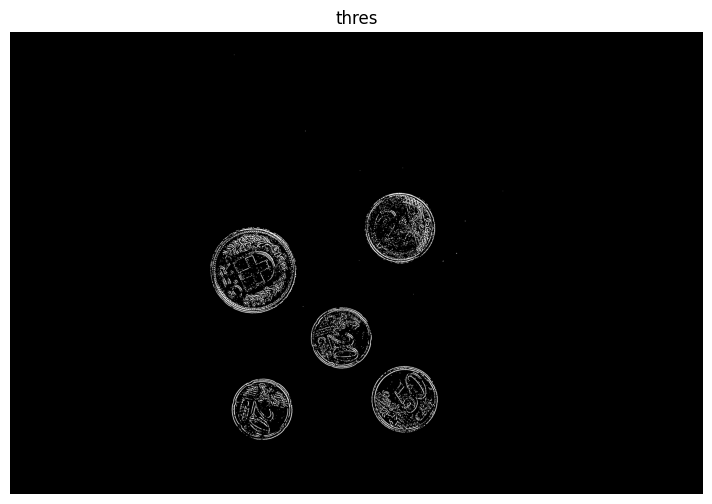

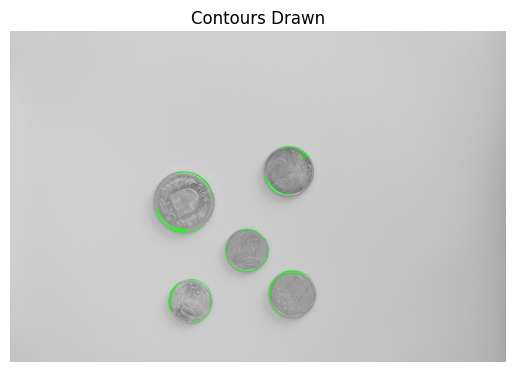

In [42]:


image_path = os.path.join('data', 'temp_test.JPG')



# 加载图像
image = cv2.imread(image_path, 0)
blur = cv2.GaussianBlur(image, (13, 13), 0)  # 应用高斯模糊去除噪声


# 自适应阈值处理
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)


# _, thresh = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # 使用OTSU二值化


thresh = cv2.bitwise_not(thresh)  # 反转二值图像

kernel = np.ones((2,2), np.uint8)
eroded = cv2.erode(thresh, kernel, iterations=1)
dilated = cv2.dilate(eroded, kernel, iterations=2)



# 使用matplotlib显示图像
plt.figure(figsize=(10, 6))
plt.imshow(dilated, cmap='gray')  # cmap='gray'确保以灰度模式显示
plt.title('thres')
plt.axis('off')  # 关闭坐标轴
plt.show()


# 找轮廓
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 过滤轮廓
min_area = 1500  # 最小面积
max_area = 30000  # 最大面积
contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt) < max_area]



contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # 转换为彩色图
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Contours Drawn')
plt.axis('off')
plt.show()


#   遍历每个轮廓并保存为图像
for i, contour in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    coin = image[y:y+h, x:x+w]
    coin_image = Image.fromarray(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))  # 转换为RGB格式
    # show the image
    coin_image.show()
    # coin_image.save(f'coin_{i}.jpg')

# print(f"Total coins detected: {len(contours)}")
